In [34]:
import os
import yaml
import torch
import torchaudio
import numpy as np

from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import Audio, display

In [4]:
DATA = Path().cwd().parent / 'data'
! ls $DATA

external  interim   processed raw


In [5]:
import librosa
import torchaudio.functional as F
import torchaudio.transforms as T

In [36]:
os.listdir(Path(os.getcwd()).parent / 'audioml')
config_path = Path(os.getcwd()).parent / 'audioml' / 'config.yaml'
print(config_path)

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

energy_config = config['preprocessing']['energy']
mel_config = config['preprocessing']['mel_spectrogram']
pitch_config = config['preprocessing']['pitch_spectrogram']

/Users/mayankanand/Documents/audio/audio/audioml/config.yaml


# Utils

In [45]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [46]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate
    
    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
        figure.suptitle(title)
        plt.show(block=False)

In [47]:
def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()
    
    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

In [48]:
def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()

In [49]:
def plot_pitch(waveform, sample_rate, pitch):
    figure, axis = plt.subplots(1, 1)
    axis.set_title("Pitch Feature")
    axis.grid(True)
    
    end_time = waveform.shape[1] / sample_rate
    time_axis = torch.linspace(0, end_time,  waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)
    
    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    ln2 = axis2.plot(
        time_axis, pitch[0], linewidth=2, label='Pitch', color='green')

    axis2.legend(loc=0)
    plt.show(block=False)

# Features

## Phoneme Duration

In [26]:
audio_path = str(DATA / 'raw' / 'LJSpeech-1.1' / 'wavs' / 'LJ001-0001.wav')
# ! ls $audio_path | head -5

In [17]:
audio_arr, sr = torchaudio.load(audio_path)

In [10]:
import tgt

In [11]:
textgrid_path = DATA.parent.parent / 'aligner' / 'data' / 'alignment'
! ls $textgrid_path | head -5

LJ001-0001.TextGrid
LJ001-0002.TextGrid
LJ001-0003.TextGrid
LJ001-0004.TextGrid
LJ001-0005.TextGrid
ls: stdout: Undefined error: 0


In [12]:
test_textgrid_path = textgrid_path / 'LJ001-0001.TextGrid'
textgrid = tgt.io.read_textgrid(test_textgrid_path)

In [13]:
ph_intervals = textgrid.get_tier_by_name("phones").intervals

In [14]:
phoneme_vocab = [
    'AA0', 'AA1', 'AA2', 'AE0', 'AE1', 'AE2', 'AH0', 'AH1', 'AH2', 
    'AO0', 'AO1', 'AO2', 'AW0', 'AW1', 'AW2', 'AY0', 'AY1', 'AY2',
    'B', 'CH', 'D', 'DH', 'EH0', 'EH1', 'EH2', 'ER0', 'ER1', 'ER2', 
    'EY0', 'EY1', 'EY2', 'F', 'G', 'HH', 'IH0', 'IH1', 'IH2', 'IY0',
    'IY1', 'IY2', 'JH', 'K', 'L', 'M', 'N', 'NG', 'OW0', 'OW1', 'OW2',
    'OY0', 'OY1', 'OY2', 'P', 'R', 'S', 'SH', 'T', 'TH', 'UH0', 'UH1',
    'UH2', 'UW0', 'UW1', 'UW2', 'V', 'W', 'Y', 'Z', 'ZH'
]

silence_token = "SIL"

In [15]:
def get_alignment(ph_intervals, sample_rate, hop_length):
    phoneme_lst = []
    duration_lst = []
    prev_idx = 0
    curr_idx = 1
    audio_start_time = 0
    audio_end_time = 0
    while curr_idx < len(ph_intervals):
        curr_interval = ph_intervals[curr_idx]
        prev_interval = ph_intervals[prev_idx]
        curr_start_time, curr_end_time, curr_phon = curr_interval.start_time, curr_interval.end_time, curr_interval.text
        prev_start_time, prev_end_time, prev_phon = prev_interval.start_time, prev_interval.end_time, prev_interval.text
    
        if (prev_idx == 0) and prev_phon != silence_token:
            phoneme_lst.append(prev_phon)
            duration = int(
                np.round(prev_end_time * sample_rate / hop_length) - 
                np.round(prev_start_time * sample_rate / hop_length)
            )
            duration_lst.append(duration)

            # Setting audio start and end time
            audio_start_time = prev_start_time
            audio_end_time = prev_end_time
            
    
        # Trimming trailing silence
        if (len(phoneme_lst) == 0) and curr_phon == silence_token:
            prev_idx += 1
            curr_idx += 1

            # Setting audio start and end time
            audio_start_time = curr_end_time
            audio_end_time = curr_end_time
            continue
    
        # Silence token for non-voiced frames    
        if curr_phon in phoneme_vocab:
            if curr_start_time != prev_end_time:
                # Add silence token in between the previous and current tokens
                phoneme_lst.append(silence_token)
                duration = int(
                    np.round(curr_start_time * sample_rate / hop_length) - 
                    np.round(prev_end_time * sample_rate / hop_length)
                )
                duration_lst.append(duration)

            phoneme_lst.append(curr_phon)
            duration = int(
                np.round(curr_end_time * sample_rate / hop_length) - 
                np.round(curr_start_time * sample_rate / hop_length)
            )
            duration_lst.append(duration)

            audio_end_time = curr_end_time
        
    
        prev_idx += 1
        curr_idx += 1

    assert len(phoneme_lst) == len(duration_lst), "Length of phoneme and duration list should be same"

    return phoneme_lst, duration_lst, audio_start_time, audio_end_time

In [19]:
hop_length = 512

In [20]:
phoneme_lst, duration_lst, start_time, end_time = get_alignment(
    ph_intervals=ph_intervals,
    sample_rate=sr,
    hop_length=hop_length
)

In [21]:
# Feature Calculations
# 1. Mel-spectrogram
# 2. Pitch Spectrogram
#     a. Pitch mean
#     b. Pitch std
# 3. Energy
# 4. Duration

In [22]:
audio_arr, sr = torchaudio.load(audio_path)
print(audio_arr.shape, sr)

torch.Size([1, 212893]) 22050


## Mel-Spectrogram

In [40]:
def calc_mel_spectrogram(filepath, config):
    # Load audio
    audio_arr, sr = torchaudio.load(filepath)

    # Resample audio if audio sample_rate doesn't match with target sample_rate
    if sr != config['sample_rate']:
        audio_arr = F.resample(
            waveform=audio_arr, 
            orig_freq=sr,
            new_freq=config['sample_rate']
        )
    
    n_fft = config['n_fft'] # 1024
    win_length = None
    hop_length = config['hop_length'] # 512
    n_mels = config['n_mels'] # 128
    sample_rate = config['sample_rate']
    # start_time = config['start_time']
    # end_time = config['end_time']
    
    # Trimming audio
    # audio_arr = audio_arr[:, int(start_time*sample_rate):int(end_time*sample_rate)]
    
    mel_spectrogram = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm='slaney',
        onesided=True,
        n_mels=n_mels,
        mel_scale="htk",
    )
    
    melspec = mel_spectrogram(audio_arr)

    return melspec, audio_arr, sample_rate

In [41]:
# mel_config = {
#     'n_fft': 1024,
#     'hop_length': 512,
#     'n_mels': 128,
#     'sample_rate': 22050,
#     'start_time': start_time,
#     'end_time': end_time
# }

mel_spec, mel_audio_arr, mel_sample_rate = calc_mel_spectrogram(
    filepath=audio_path,
    config=mel_config
)

/Users/mayankanand/Documents/audio/.env/lib/python3.10/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


In [43]:
mel_spec.shape

torch.Size([1, 128, 832])

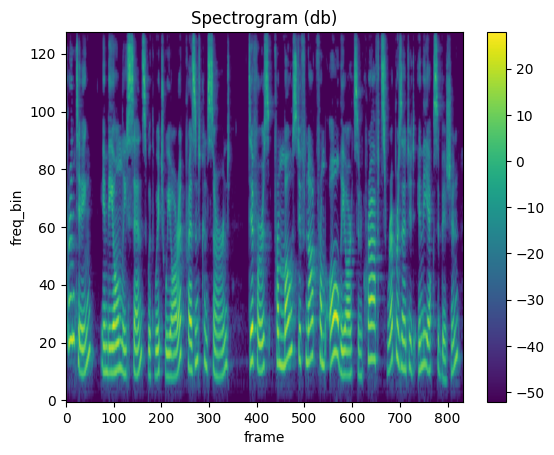

Mel-Spectrogram shape: torch.Size([1, 128, 832])


In [50]:
plot_spectrogram(mel_spec[0])
print(f"Mel-Spectrogram shape: {mel_spec.shape}")

## Pitch Spectrogram

In [86]:
import pywt
import numpy as np
import pyworld as pw
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [179]:
def calc_pitch_spectrogram(filepath, config: dict):
    hop_length = config['hop_length']
    sr = config['sample_rate']
    
    fs, x = wav.read(filepath)
    x = x.astype(np.float64)

    # if len(x.shape) > 1:
    #     x = x[:, int(start_time * sample_rate):int(end_time * sample_rate)]
    # else:
    #     x = x[int(start_time * sample_rate):int(end_time * sample_rate)]

    # Extract raw F0 using WORLD
    _f0, t = pw.harvest(x, fs, frame_period=hop_length / sr * 1000)
    f0 = pw.stonemask(x, _f0, t, fs)

    # Interpolate unvoiced frames
    valid = f0 > 0
    f0_interp = interp1d(t[valid], f0[valid], kind='linear', fill_value='extrapolate')
    f0_filled = f0_interp(t)

    # Step 3: Normalize pitch contour (log scale)
    f0_log = np.log(f0_filled)
    f0_mean, f0_std = np.mean(f0_log), np.std(f0_log)
    f0_norm = (f0_log - f0_mean) / f0_std

    # Apply Continuous Wavelet Transform
    tau = config['tau']
    band = config['band']

    scale = [2**(i+1)*tau for i in range(band)]
    sample_rate = 1 / tau
    scale_factor = [int(np.round(s * sample_rate)) for s in scale]
    print(scale_factor)
    
    coeffs, freqs = pywt.cwt(f0_norm, scale_factor, 'mexh')
    return coeffs, f0_norm, f0_mean, f0_std, t


def reconstruct_pitch_contour(pitch_spec, config: dict):

    # tau = config['tau']
    band = config['band']

    weights = [(i + 2.5)**(-2.5) for i in range(band)]

    components = []
    for idx, f0_scale in enumerate(pitch_spec):
        components.append(f0_scale * weights[idx])

    components = np.array(components)
    return np.sum(components, axis=0)

def icwt(pitch_spec, f0_mean, f0_std):
    """
    - pitch_spec: (batch x sequence_length x cwt_bins)
    """
    batch, seq_len, cwt_bins = pitch_spec.shape
    
    weights = (torch.arange(cwt_bins) + 2.5)**(-2.5)
    weights = weights.unsqueeze(0).expand(seq_len, -1)

    _pitch_spec = pitch_spec * weights
    _f0 = torch.sum(_pitch_spec, dim=-1)

    f0 = (_f0 * f0_std) + f0_mean
    return f0

In [180]:
new_audio_path = Path(audio_path).parent / 'LJ015-0243.wav'

In [181]:
pitch_spectrogram, f0_norm, f0_mean, f0_std, t = calc_pitch_spectrogram(
    new_audio_path, 
    config=pitch_config
)

# pitch_spectrogram, f0_norm, f0_mean, f0_std, t = calc_pitch_spectrogram(
#     audio_path, 
#     config=pitch_config
# )

[2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]


/var/folders/09/3m09y2cx0cq_1x4gp8q0ng2m0000gn/T/ipykernel_35676/1081519704.py:23: RuntimeWarning: invalid value encountered in log
  f0_log = np.log(f0_filled)


In [182]:
pitch_spectrogram.shape

(10, 544)

In [146]:
fs, x = wav.read(new_audio_path)
x = x.astype(np.float64)

# fs, x = wav.read(audio_path)
# x = x.astype(np.float64)

In [161]:
pitch_config

{'tau': 0.005, 'band': 10, 'hop_length': 256, 'sample_rate': 22050}

In [199]:
# pitch_config = {
#     'tau': 0.005,
#     'band': 10,
#     'hop_length': 512,
#     'sample_rate': sr
# }

# Calculating pitch spectrogram from audio waveform
pitch_spectrogram, f0_norm, f0_mean, f0_std, t = calc_pitch_spectrogram(
    audio_path, 
    # start_time=start_time,
    # end_time=end_time,
    config=pitch_config
)

[2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]


In [200]:
pitch_spec = torch.tensor(pitch_spectrogram, dtype=torch.float32).unsqueeze(0).transpose(1, 2)
print(f"pitch_spectrogram shape: {pitch_spec.shape} | f0_mean: {f0_mean} | f0_std: {f0_std}")

pitch_spectrogram shape: torch.Size([1, 832, 10]) | f0_mean: 5.435440421020885 | f0_std: 0.2510731971684418


In [201]:
f0_mean = torch.tensor(f0_mean, dtype=torch.float32)
f0_std = torch.tensor(f0_std, dtype=torch.float32)

rc_pitch_contour = icwt(
    pitch_spec=pitch_spec, 
    f0_mean=f0_mean,
    f0_std=f0_std
)

In [207]:
_rc_pitch_contour = rc_pitch_contour.squeeze().numpy()

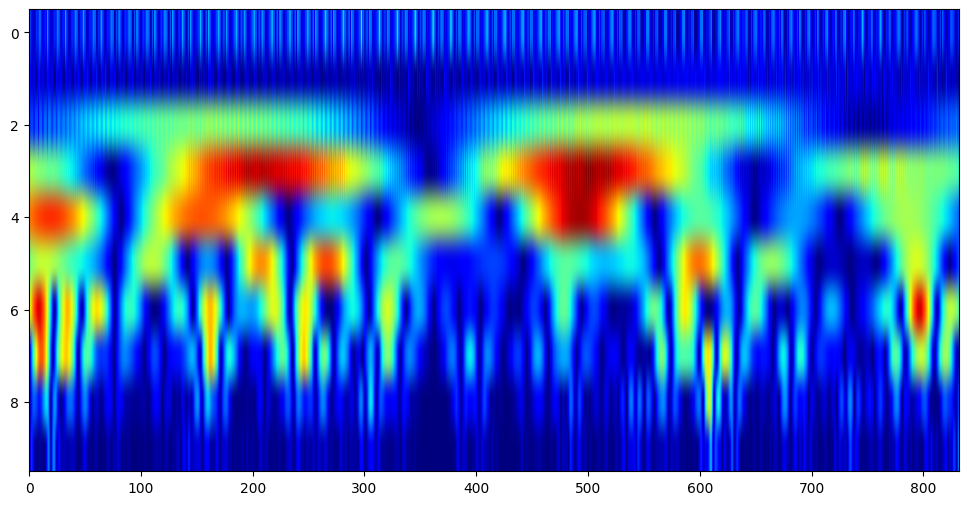

In [218]:
plt.figure(figsize=(12, 6))
plt.imshow(np.abs(pitch_spec.squeeze().transpose(0, 1).numpy()[::-1, :]), aspect='auto', cmap='jet')
plt.show()

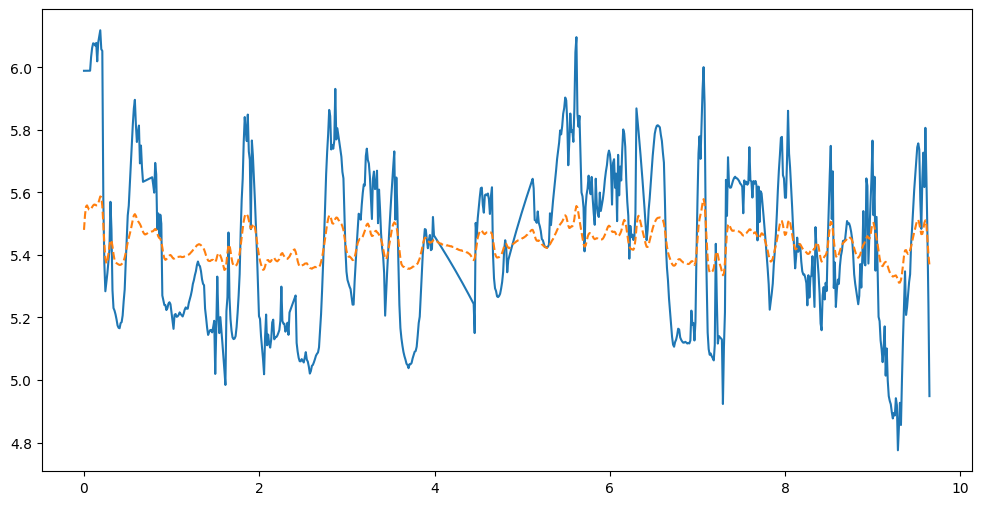

In [223]:
f0_intrp = f0_norm * f0_std.numpy() + f0_mean.numpy()
plt.figure(figsize=(12, 6))
# plt.plot(t, f0_norm, label='F0 Norm')
plt.plot(t, f0_intrp, label="F0 Interpolated")
plt.plot(t, _rc_pitch_contour, label="F0 reconstructed", linestyle='--')
plt.show()

In [ ]:
# Reconstructing pitch contour
reconstructed_pitch = reconstruct_pitch_contour(pitch_spectrogram, config=pitch_config)

[2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]


In [164]:
scale = [2**(i+1)*pitch_config['tau'] for i in range(10)]
sample_rate = 1 / 0.005
scale_factor = [int(np.round(s * sample_rate)) for s in scale]

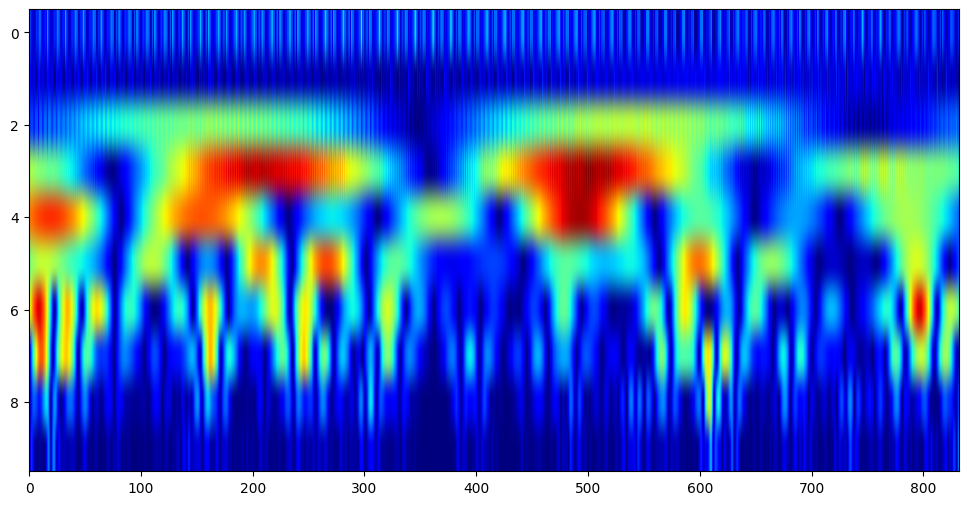

In [165]:
plt.figure(figsize=(12, 6))
plt.imshow(np.abs(pitch_spectrogram[::-1, :]), aspect='auto', cmap='jet')
plt.show()

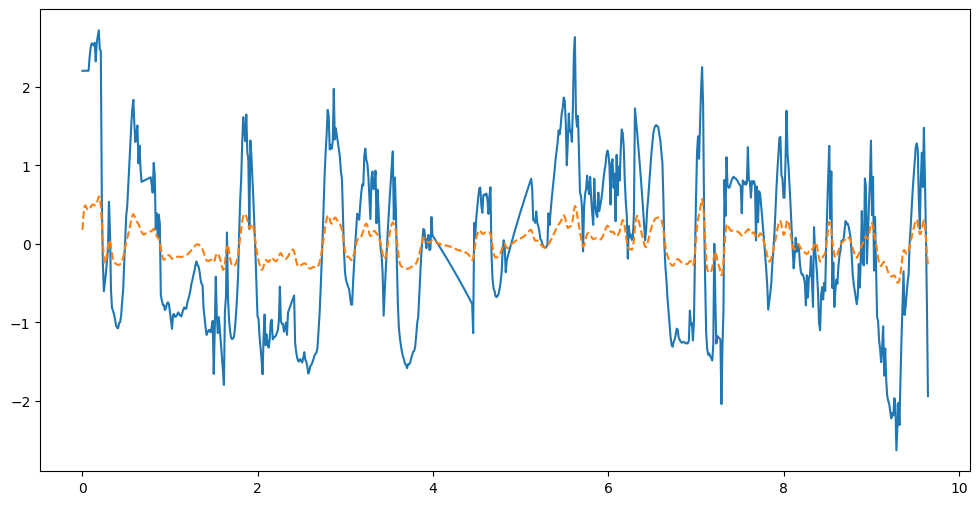

In [166]:
f0_intrp = f0_norm * f0_std + f0_mean
plt.figure(figsize=(12, 6))
plt.plot(t, f0_norm, label='F0 Norm')
# plt.plot(t, f0_intrp, label="F0 Interpolated")
plt.plot(t, reconstructed_pitch, label="F0 Interpolated", linestyle='--')
plt.show()

## Energy

In [6]:
# def calculate_stft_energy(waveform, start_time, end_time, sample_rate=22050, n_fft=1024, hop_length=512, win_length=1024):
#     """
#     Calculate energy using L2-norm of STFT as described in FastSpeech2 paper
    
#     Args:
#     - waveform: Input audio tensor [1, num_samples] or [num_samples]
#     - sample_rate: Sampling rate of the audio
#     - n_fft: Number of FFT components
#     - hop_length: Number of samples between successive frames
#     - win_length: Each frame of audio will be windowed with a window of this length
    
#     Returns:
#     - energy: Tensor of energy values for each frame
#     """
#     # Ensure waveform is 1D
#     if waveform.dim() > 1:
#         waveform = waveform.squeeze(0)
#         waveform = waveform[int(start_time * sample_rate) : int(end_time * sample_rate)]
    
#     # Create window
#     window = torch.hann_window(win_length)
    
#     # Compute STFT
#     # Use torch.stft directly from torch.signal
#     stft_complex = torch.stft(
#         waveform, 
#         n_fft=n_fft, 
#         hop_length=hop_length, 
#         win_length=win_length,
#         window=window,
#         center=True,
#         normalized=False,
#         onesided=True,
#         return_complex=False  # Returns real and imaginary parts separately
#     )
    
#     # Calculate magnitude (L2-norm)
#     # For non-complex output, manually calculate magnitude
#     # stft_complex shape: [num_freq, num_frames, 2] (real and imaginary parts)
#     stft_magnitude = torch.sqrt(stft_complex[..., 0]**2 + stft_complex[..., 1]**2)
    
#     # Sum across frequency bins to get energy per frame
#     frame_energy = torch.sum(stft_magnitude**2, dim=0)
    
#     # Optional: Normalize energy
#     frame_energy = frame_energy / (frame_energy.max() + 1e-8)
    
#     return frame_energy

In [7]:
def calculate_stft_energy(filepath, config):
    """
    Calculate energy using L2-norm of STFT as described in FastSpeech2 paper
    
    Args:
    - waveform: Input audio tensor [1, num_samples] or [num_samples]
    - sample_rate: Sampling rate of the audio
    - n_fft: Number of FFT components
    - hop_length: Number of samples between successive frames
    - win_length: Each frame of audio will be windowed with a window of this length
    
    Returns:
    - energy: Tensor of energy values for each frame
    """

    sample_rate = config['sample_rate']
    hop_length = config['hop_length']
    n_fft = config['n_fft']
    win_length = config['win_length']

    waveform, sr = torchaudio.load(filepath)

    if sr != sample_rate:
        waveform = F.resample(
            waveform=waveform, 
            orig_freq=sr,
            new_freq=sample_rate
        )

    # Ensure waveform is 1D
    if waveform.dim() > 1:
        waveform = waveform.squeeze(0)
    
    # Create window
    window = torch.hann_window(win_length)
    
    # Compute STFT
    # Use torch.stft directly from torch.signal
    stft_complex = torch.stft(
        waveform, 
        n_fft=n_fft, 
        hop_length=hop_length, 
        win_length=win_length,
        window=window,
        center=True,
        normalized=False,
        onesided=True,
        return_complex=False  # Returns real and imaginary parts separately
    )
    
    # Calculate magnitude (L2-norm)
    # For non-complex output, manually calculate magnitude
    # stft_complex shape: [num_freq, num_frames, 2] (real and imaginary parts)
    stft_magnitude = torch.sqrt(stft_complex[..., 0]**2 + stft_complex[..., 1]**2)
    
    # Sum across frequency bins to get energy per frame
    frame_energy = torch.sum(stft_magnitude**2, dim=0)
    
    # Optional: Normalize energy
    frame_energy = frame_energy / (frame_energy.max() + 1e-8)
    
    return frame_energy

In [13]:
import os
from pathlib import Path

/Users/mayankanand/Documents/audio/audio/audioml/config.yaml


In [28]:
frame_energy = calculate_stft_energy(audio_path, energy_config)

/Users/mayankanand/Documents/audio/.env/lib/python3.10/site-packages/torch/functional.py:709: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/SpectralOps.cpp:878.)
  return _VF.stft(  # type: ignore[attr-defined]


In [30]:
frame_energy.shape

torch.Size([832])

In [68]:
def visualize_stft_energy(waveform, energy, sample_rate):
    """
    Visualize waveform and corresponding STFT energy
    """
    # Create time axes
    time_waveform = torch.arange(waveform.shape[0]) / sample_rate
    time_energy = torch.linspace(0, time_waveform[-1], energy.shape[0])
    
    # Plot
    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(time_waveform, waveform)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    plt.subplot(2, 1, 2)
    plt.plot(time_energy, energy)
    plt.title('STFT Energy (L2-norm)')
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Energy')
    
    plt.tight_layout()
    plt.show()

In [69]:
audio_arr, sr = torchaudio.load(audio_path)

In [71]:
energy = calculate_stft_energy(
    waveform=audio_arr,
    start_time=start_time,
    end_time=end_time
)

In [72]:
energy.shape, audio_arr.shape

(torch.Size([414]), torch.Size([1, 212893]))

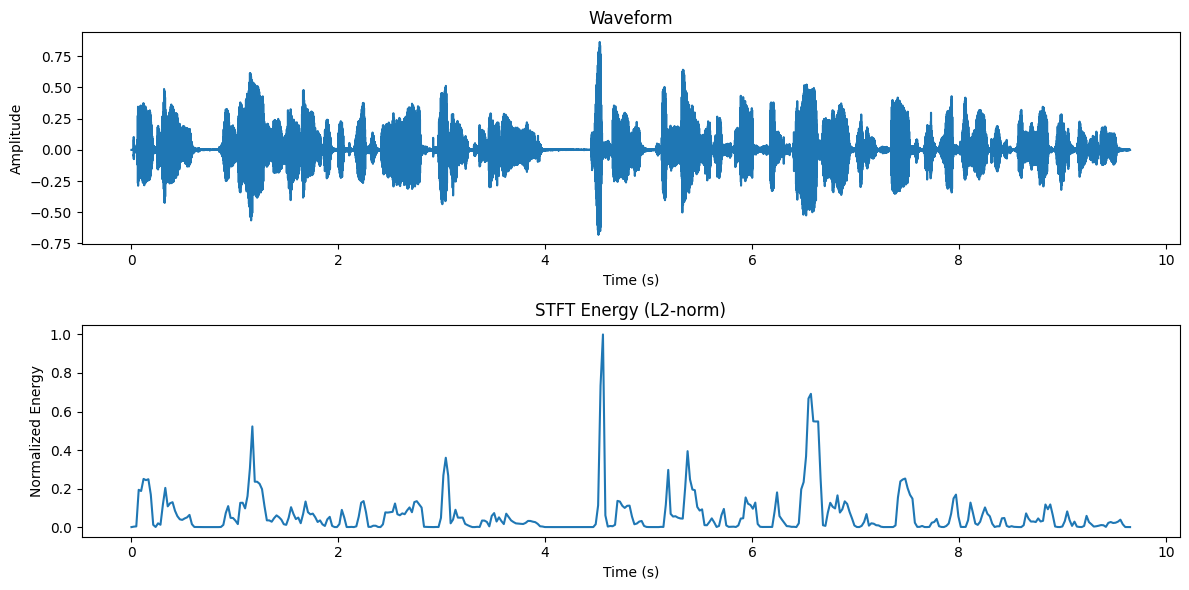

In [73]:
visualize_stft_energy(audio_arr.squeeze(), energy, sample_rate=sr)

In [77]:
mel_spec.shape, pitch_spectrogram.shape, energy.shape

(torch.Size([1, 128, 414]), (10, 414), torch.Size([414]))

# Text-to-Phoneme

In [106]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/mayankanand/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [78]:
from g2p_en import G2p

texts = ["I have $250 in my pocket.", # number -> spell-out
         "popular pets, e.g. cats and dogs", # e.g. -> for example
         "I refuse to collect the refuse around here.", # homograph
         "I'm an activationist."] # newly coined word
g2p = G2p()
for text in texts:
    out = g2p(text)
    print(out)

['AY1', ' ', 'HH', 'AE1', 'V', ' ', 'T', 'UW1', ' ', 'HH', 'AH1', 'N', 'D', 'R', 'AH0', 'D', ' ', 'F', 'IH1', 'F', 'T', 'IY0', ' ', 'D', 'AA1', 'L', 'ER0', 'Z', ' ', 'IH0', 'N', ' ', 'M', 'AY1', ' ', 'P', 'AA1', 'K', 'AH0', 'T', ' ', '.']
['P', 'AA1', 'P', 'Y', 'AH0', 'L', 'ER0', ' ', 'P', 'EH1', 'T', 'S', ' ', ',', ' ', 'F', 'AO1', 'R', ' ', 'IH0', 'G', 'Z', 'AE1', 'M', 'P', 'AH0', 'L', ' ', 'K', 'AE1', 'T', 'S', ' ', 'AH0', 'N', 'D', ' ', 'D', 'AA1', 'G', 'Z']
['AY1', ' ', 'R', 'IH0', 'F', 'Y', 'UW1', 'Z', ' ', 'T', 'UW1', ' ', 'K', 'AH0', 'L', 'EH1', 'K', 'T', ' ', 'DH', 'AH0', ' ', 'R', 'EH1', 'F', 'Y', 'UW2', 'Z', ' ', 'ER0', 'AW1', 'N', 'D', ' ', 'HH', 'IY1', 'R', ' ', '.']
['AY1', 'M', ' ', 'AE1', 'N', ' ', 'AE2', 'K', 'T', 'IH0', 'V', 'EY1', 'SH', 'AH0', 'N', 'IH0', 'S', 'T', ' ', '.']


In [83]:
# g2p("This is the city of joy called Mumbai")

In [95]:
import os

In [100]:
textgrid_file_dir = Path('/') / 'Users' / 'mayankanand' / 'Documents' / 'audio' / 'aligner' / 'data' / 'alignment'

In [101]:
textgrid_files = os.listdir(textgrid_file_dir)

In [102]:
textgrid_files[:5]

['LJ039-0231.TextGrid',
 'LJ038-0039.TextGrid',
 'LJ039-0057.TextGrid',
 'LJ050-0158.TextGrid',
 'LJ020-0080.TextGrid']

In [114]:
set1 = {2, 3, 4}
set2 = {3, 1, 6}

set1.union(set2)

{1, 2, 3, 4, 6}

In [118]:
from tqdm import tqdm

In [119]:
mfa_vocab = set()
for file in tqdm(textgrid_files):
    textgrid = tgt.io.read_textgrid(str(textgrid_file_dir / file))
    phonemes = set([x.text for x in textgrid.get_tier_by_name('phones').intervals])
    mfa_vocab = mfa_vocab.union(phonemes)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13084/13084 [00:07<00:00, 1837.78it/s]


In [126]:
mfa_vocab

{'AA0',
 'AA1',
 'AA2',
 'AE0',
 'AE1',
 'AE2',
 'AH0',
 'AH1',
 'AH2',
 'AO0',
 'AO1',
 'AO2',
 'AW0',
 'AW1',
 'AW2',
 'AY0',
 'AY1',
 'AY2',
 'B',
 'CH',
 'D',
 'DH',
 'EH0',
 'EH1',
 'EH2',
 'ER0',
 'ER1',
 'ER2',
 'EY0',
 'EY1',
 'EY2',
 'F',
 'G',
 'HH',
 'IH0',
 'IH1',
 'IH2',
 'IY0',
 'IY1',
 'IY2',
 'JH',
 'K',
 'L',
 'M',
 'N',
 'NG',
 'OW0',
 'OW1',
 'OW2',
 'OY0',
 'OY1',
 'OY2',
 'P',
 'R',
 'S',
 'SH',
 'T',
 'TH',
 'UH0',
 'UH1',
 'UH2',
 'UW0',
 'UW1',
 'UW2',
 'V',
 'W',
 'Y',
 'Z',
 'ZH',
 'spn'}

In [121]:
len(mfa_vocab)

70

In [123]:
textgrid.get_tier_names()

['words', 'phones']

In [124]:
[x.text for x in textgrid.get_tier_by_name('words')]

['lee',
 'has',
 'to',
 'be',
 'diagnosed',
 'as',
 'quote',
 'personality',
 'pattern',
 'disturbance',
 'with',
 'schizoid',
 'features',
 'and',
 'passive',
 'aggressive',
 'tendencies',
 'end',
 'quote']

In [125]:
[x.text for x in textgrid.get_tier_by_name('phones')]

['L',
 'IY1',
 'HH',
 'AE1',
 'Z',
 'T',
 'IH0',
 'B',
 'IY0',
 'D',
 'AY2',
 'AH0',
 'G',
 'N',
 'OW1',
 'S',
 'T',
 'AE1',
 'Z',
 'K',
 'W',
 'OW1',
 'T',
 'P',
 'ER2',
 'S',
 'AH0',
 'N',
 'AE1',
 'L',
 'IH0',
 'T',
 'IY0',
 'P',
 'AE1',
 'T',
 'ER0',
 'N',
 'D',
 'IH0',
 'S',
 'T',
 'ER1',
 'B',
 'AH0',
 'N',
 'S',
 'W',
 'IH0',
 'TH',
 'spn',
 'F',
 'IY1',
 'CH',
 'ER0',
 'Z',
 'AH0',
 'N',
 'D',
 'P',
 'AE1',
 'S',
 'IH0',
 'V',
 'AH0',
 'G',
 'R',
 'EH1',
 'S',
 'IH0',
 'V',
 'T',
 'EH1',
 'N',
 'D',
 'AH0',
 'N',
 'S',
 'IY0',
 'Z',
 'EH1',
 'N',
 'D',
 'K',
 'W',
 'OW1',
 'T']

# Alignment Text-Speech

# Rough